I will use this notebook to generate a couple of .csv files to use for testing my minimal IMAP program. First I will just create a simple on with 10 nodes.

In [1]:
import numpy as np
import scipy.sparse as sp
import csv
import time
from random import randint
from bokeh import plotting as plt
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
from ipywidgets import interact
import pandas as pd
output_notebook()
from bokeh.models import widgets as wid
from bokeh.models import GraphRenderer, StaticLayoutProvider, Circle, HoverTool, BoxZoomTool, ResetTool, MultiLine
from bokeh.palettes import Spectral8, Inferno8
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes, from_networkx
from numpy import pi as pi
import networkx as nx
from numpy import ndarray, array, asarray
import bokeh.layouts as layout
from math import cos, sin
from functools import partial
import matplotlib.pyplot as plot
import timeit

Loading BokehJS ...

In [2]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def sprandsym(n, density):
    X = sp.rand(n, n, density = density)
    upper_X = sp.triu(X) 
    result = upper_X - sp.diags(X.diagonal())
    result = result.A
    for i in range(size):
        factor = sum(result[i,:]) + 10
        result[i, i:size] = result[i, i:size]/factor
        result[i:size, i] = result[i:size, i]/factor
    result = result + np.identity(n)
    return result

numSamples = 100;
size = 8
#covMat = sprandsym(size, .2)
covMat = np.identity(8)
covMat[0,1] = .9; covMat [0,2] = .9; covMat[1,3] = .9; covMat[0,6] = .9; covMat[2,5] = .9; covMat[3,7] = .9
print(covMat)
covMat = np.linalg.inv(covMat)
covMat = covMat - np.tril(covMat, -1)
    
means = np.asarray([0 for i in range(size)])

with open('.\speedTest.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(np.asarray([str(i) for i in range(size)]))
    for n in range(numSamples):
        samples = np.random.multivariate_normal(means, covMat)
        writer.writerow(samples)

[[1.  0.9 0.9 0.  0.  0.  0.9 0. ]
 [0.  1.  0.  0.9 0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.9 0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.9]
 [0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1. ]]


C:\Users\Mirae\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: covariance is not positive-semidefinite.


In [2]:
from causaldag import DAG
from causaldag.utils.ci_tests import gauss_ci as gc
from numpy import identity, dot, log, pi, mod, copy, append, asarray, asmatrix, exp, zeros, log1p, concatenate, arange
from numpy.linalg import det
from numpy.random import choice, randint, permutation, uniform

def logLike(DAG, dataDict):
    """
    likelihood essentially return the marginal likelihood of the data given the graph. Based on the 2014 Addendum
    :param DAG: the directed acyclic graph object that we are evaluating
    :param dataDict: the dictionary conatining lots of the relevant information aboout the data, including sample mean
    and covariance.
    
    :return marLik" the marginal likelihood of the current graph structure given the data
    """
    marLik = 0 
    alphaMu = 1 #Currently I arbitrarily fix this hyperparameter - should look more into what this means though
    N = dataDict['n']
    ESS = len(DAG.nodes) + 20 ###  I NEED TO CHANGE THIS - I thought ESS = sample num - num edges estimated
    T = alphaMu*(ESS - len(DAG.nodes) - 1)/(alphaMu + 1)*identity(len(DAG.nodes))  #suggested value for T
    R = T + dataDict['Sn'] + (N*ESS/(N + ESS))*(dot(dataDict['mu'], dataDict['mu']))
    for n in DAG.nodes:
        parents = DAG.upstream(n)
        #p(d|DAG) = prod p(d(Pa_i U {X_i})| DAG)/p(d(Pa_i)| DAG):
        marLik += scoreHelp(parents.union({n}), parents, ESS, R, N, alphaMu, len(DAG.nodes))
    return marLik
    
def scoreHelp(qs, ps, ESS, R, N, aMu, n):
    """
    scoreHelp will compute the log marginal likelihood of a subset of nodes of the graph (typical parents of a
    particular node or the union of the parents of a node with the node itself)
    :param qs: the indices of the set of all parents of node x and x
    :param ps: the indices of the set of all parents of node x
    :param ESS: the effective sample size (also referred to as alpha_w) 
    :param R: matrix which integrate information from the data/prior
    :param N: the number of data points
    :param aMu: a hyperparameter greater than 0
    :param n: the number of nodes in the graph
    
    :return retVal: the marginal likelihood of the data given this part of the graph.
    """
    #define these so that we can properly select the right rows/columns to use:
    xsQ = asarray([[i] for i in qs])
    ysQ = asarray([i for i in qs])
    xsP = asarray([[i] for i in ps])
    ysP = asarray([i for i in ps])
    
    p = len(ps) # number of parents
    
    retVal = (-N/2)*log(pi) + (1/2)*log((aMu)/(N + aMu))
    for i in range(int(N/2)): #rather than using the gamma function, just add the sum of the logs of the remainder
        retVal += log((2*i + ESS - n + p + 1)/2)
    retVal += ((ESS - n + 2*p + 1)/2)*log((aMu*(ESS - n - 1))/(aMu + 1))
    retVal -= ((N + ESS - n + p + 1)/2)*log(det(R[xsQ,ysQ]))
    if not len(ysP) == 0: #determinant of 0x0 matrix is taken to be one
        retVal +=  ((N + ESS - n + p)/2)*log(det(R[xsP,ysP]))
    return(retVal)

def transposePerm(perm):
    """
    returns a random new permutation diven the old permutation, as well as whether there was a full swap
    
    :param perm: the current permutation
    
    :return: A new transpoisiton, two side by side elements are selected at random to be swapped. And min index of transposition 
    """
    newInd = randint(0, len(perm) - 1)
    #Find the neighbor to switch:
    neighbor = mod(newInd + choice([-1,1]), len(perm))
    newPerm = copy(perm)
    newPerm[newInd] = perm[neighbor]
    newPerm[neighbor] = perm[newInd]
    
    return(newPerm, newInd, neighbor)

def newIMAP(perm, alpha, dataDict):
    """
    Creates a new graph object representing the graphical structure of the data, given a permutation.
    :param perm: an array containing an ordering of indices to construct the graph out of
    :param alpha: the confidence level to use for edge construction
    :param dataDict: dictionary structure contianing n: number of data points and C: the correlation matrix of the data
    
    :return newIMAP: a graphical structure representing the new IMAP with the new desired structure. 
    """
    
    IMAP = DAG() #create a new empty graph
    IMAP.add_nodes_from(asarray([k for k in range(len(perm))]))
    
    for i in range(len(perm) -1):
        for j in range(i+1, len(perm)):
            parents = append(asarray(range(i)), asarray(range(i+1,j)))
            S = asarray([perm[p] for p in parents.astype(int)]) #all potential parents of j (other than i) given the perm
            newEdge = gc.gauss_ci_test(dataDict, perm[i], perm[j], S, alpha)
            if newEdge['reject']:
                IMAP.add_arc(perm[i], perm[j])        
    return(IMAP)    
    

def UMI(gCurr, perm, minInd, dataDict, alpha):
    """
    Updates the IMAP in the case that it was not just an exchange of the first and last index (so there are repeated edges).
    
    :param gCurr: DAG structure from the previous acceptance
    :param perm: the new permutation that the new graph is being bult from
    :param minInd: the minimal index exhanged in permutation
    :param dataDict: dictionary structure contianing n: number of data points and C: the correlation matrix of the data
    
    :return gNew: the new graphical structure representing the updated DAG structure.
    """
    
    gNew = DAG()
    edges = gCurr.arcs #take all current arcs from 
    gNew.add_nodes_from(gCurr.nodes)
    if (perm[minInd + 1], perm[minInd]) in edges: #only need to update arcs if the flipped edge was in the original graph
        edges.remove((perm[minInd + 1], perm[minInd]))
        for i in range(minInd):
            for j in asarray([minInd, minInd + 1]):
                parents = append(asarray(range(i)), asarray(range(i+1,j)))
                S = asarray([perm[p] for p in set(parents.astype(int))])
                newEdge = gc.gauss_ci_test(dataDict, perm[i], perm[j], S, alpha)
                if newEdge['reject']: #if we cannot show conditional independnence then we need an edge:
                    edges.add((perm[i], perm[j]))
                elif (perm[i], perm[j]) in edges:
                    edges.remove((perm[i], perm[j]))
        edges.add((perm[minInd], perm[minInd + 1]))
    gNew.add_arcs_from(edges)
    return(gNew)

def minIMAP_MCMC(dataDict, burnIn = 50, alpha = .05, justEdges = False, gamma = 1, nSteps = 500, thinning = 1, verbose = True):
    
    """
    Runs an MCMC algorithm to explore the minimal IMAPs which describe the data.

    :param dataPath: string with the folder address of the data
    :param burnIn: the number of steps to throw out to allow for a burnIn period for the MCMC algorithm. Defaults to 50
    :param alpha: confidence level to use as cutoff for the data.  Defaults to 0.05
    :param justEdges: a boolean value to allow for the user to just choose to get edge estimates rather than all sampled graphs
    :param gamma: the sparsity strength.  Defaults to 1
    :param nsteps: the number of steps to run the MCMC algorithm for.  Defaults to 500
    :param thinning: how many steps to wait before saving a graph.  Defualts to 1
    :param verbose: turns on and off the update message printing

    :return edgeProb: the expectation value of the probability that a given edge is a feature
    :return edgeCount: the evolving counts which show where new edges are seen
    :return logPart: the log partition function
    :return logProb: the matrix which shows the evolution of the log of the posterior for each edge
    :return graphSamples: a collection of all graphs sampled in the MCMC algorithm. 
    """

    perm = permutation(arange(dataDict["p"])) #generate random new permutation to start searching with
    gMap = newIMAP(perm, alpha, dataDict) #create a new random IMAP
    graphSamples = [] # the sampled graphs we return to the user
    count = 0 ; norm = 0 #to help us count number of accepted graphs/number saved graphs
    postOn = [0 for i in range(len(perm)**2)]; postOff = [0 for i in range(len(perm)**2)];
    logProb = []
    edgeCounts = asmatrix([[0 for k in range(len(perm)**2)]])

    for s in range(nSteps):
        if ((mod(s, int(nSteps/20)) == 0) & (verbose)) :
            print(str(int(100*s/nSteps)) + '% Done!')
        
        nPerm, i, j = transposePerm(perm)
        if min(i,j) == 0 and max(i,j) == dataDict["p"] - 1: #ie the first and last nodes are exchanged
            gNew = newIMAP(nPerm, alpha, dataDict)
        else:
            gNew = UMI(gMap, nPerm, min(i,j), dataDict, alpha)
        oldLik = logLike(gMap, dataDict)
        newLik = logLike(gNew, dataDict)
        tProb = (newLik - gamma*len(gNew.arcs)) - (oldLik - gamma*len(gMap.arcs))
        if uniform() < exp(tProb): #If np.exp(tProb) > 1 then we will always accept - as required
            count += 1 #by using count rather than s we can gaurantee that we don't skip over the thinning step
            gMap = gNew
            perm = nPerm
            if count > burnIn and mod(count, thinning) == 0:
                norm += 1
                post = newLik - gamma*len(gNew.arcs)
                newProbs = zeros([len(perm)**2])
                for m in range(len(perm)):
                    for n in range(len(perm)):
                        ind = m*len(perm) + n
                        newProbs[ind] = (norm - 1)*edgeCounts[(len(edgeCounts[:,0]) -1), ind]
                        if (m,n) in gMap.arcs:
                            postOn[ind] += post
                            ind = m*len(perm) + n
                            newProbs[ind] += 1
                        else:
                            postOff[ind] += post
                
                edgeCounts = concatenate((edgeCounts, asmatrix(newProbs/norm)), axis = 0)
                if not justEdges:
                    graphSamples.append(gMap)
                logProb.append(post)
    
    return(edgeCounts, graphSamples, logProb, postOn, postOff)

In [3]:
#a synthetic dataset
fileName = '.\speedTest.csv'
data = pd.read_csv(fileName)
dataDict = {'n': len(data.index), 'C': asarray(data.corr()), 'p': len(data.columns), 'mu': asarray(data.mean()),
            'Sn': asarray(data.cov())}
names = data.columns
numRepeats = 10
traces = dict()
#initialize:
for c in range(len(names)**2):
    traces[str(c)] = []

start = timeit.timeit()
for i in range(numRepeats):
    print(str(100*i/numRepeats) + "% Done")
    evolve, gs, lp, pOn, pOff = minIMAP_MCMC(dataDict, burnIn = 2500, alpha = 0.05, justEdges = True, gamma = 1, 
        nSteps = 100000, thinning = 100, verbose = False)
    evolve = np.asmatrix(evolve)
    for b in range(len(names)**2):
        edge = np.array(evolve[:,b])
        traces[str(b)].append(edge)
end = timeit.timeit()
print(end - start)

0.0% Done
10.0% Done
20.0% Done
30.0% Done
40.0% Done
50.0% Done
60.0% Done
70.0% Done
80.0% Done
90.0% Done
-0.00866020973484578


In [6]:
def confInt(pEst, stepSz):
    """
    confInt will return a series of x and y points to define a polygon patch represting the confidence interval over
    the estimate for any given edge.
    """
    k = 0
    yBot = []; xBot = [] 
    yTop = []; xTop = [] #lists to put polygon intergers in
    while (k*stepSz + 10) < len(pEst):
        i = k*stepSz + 10
        sd = (pEst[i]*(1 - pEst[i])/(i))**(1/2)
        yTop.append(pEst[i] + sd)
        xTop.append(i)
        yBot.insert(0, pEst[i] - sd)
        xBot.insert(0, i)
        k += 1
    
    return(yTop + yBot, xTop + xBot)

In [7]:
#Here, I give option to sum across paired edges, or not.  If not wanting to sum, simply delete adding pTrace in for loop
edge = 3
dim = int((len(traces))**(1/2))
threshold = .9
dif_edges = .1
a = np.mod(edge, dim); b = (edge-a)/dim
pair = dim*a + b
eTrace = traces[str(edge)]
pTrace = traces[str(int(pair))]

p = plt.figure()
p.plot_width = 600
p.plot_height = 600
p.title.text_font_size = "15px"
p.yaxis.axis_label = "Probability of Edges"
p.xaxis.axis_label = "Number of Samples from the Posterior"
c = 0
for k in range(7):
    r = traces[str(edge)][k]
    p.line(np.asarray([j for j in range(len(r))]), np.squeeze(r), color = 'darkseagreen', line_width = 3)
    confY, confX = confInt(ndarray.flatten(array(np.squeeze(r))), 5)
    p.patch(x = confX, y = confY, color = '#99d8c9', alpha = 0.2)
show(p)
print(start)


0.018534301544097475


In [34]:
fileName = '.\speedTest.csv'
data = pd.read_csv(fileName)
dataDict = {'n': len(data.index), 'C': asarray(data.corr()), 'p': len(data.columns), 'mu': asarray(data.mean()),
            'Sn': asarray(data.cov())}
evolve, gs, lp, pOn, pOff = minIMAP_MCMC(dataDict, burnIn = 2500, alpha = 0.05, justEdges = True, gamma = 1, 
        nSteps = 5000, thinning = 1)
evolveAcu = np.asmatrix(evolve)

0% Done!
5% Done!
10% Done!
15% Done!
20% Done!
25% Done!
30% Done!
35% Done!
40% Done!
45% Done!
50% Done!
55% Done!
60% Done!
65% Done!
70% Done!
75% Done!
80% Done!
85% Done!
90% Done!
95% Done!


In [17]:
p = []
threshold = 0.95
for b in range(8**2):
    edge = np.array(evolveAcu[:,b])
    edge = np.squeeze(edge)
    p.append(edge[-1])
p = np.asarray(p)
p = p.reshape([8,8])   
for b in range(8):
    for c in range(b):
        p[c,b] += p[b,c]
        p[b,c] = 0
pred = np.double(np.asarray(p) > threshold)  
pred = np.ndarray.flatten(pred)   

covMat = np.zeros([8,8])
covMat[0,1] = .9; covMat [0,2] = .9; covMat[1,3] = .9; covMat[0,6] = .9; covMat[2,5] = .9; covMat[3,7] = .9
truth = np.ndarray.flatten(np.double(covMat > 0))

tp = sum(truth*pred)
fp = sum((1-truth)*pred)
fn = sum(truth*(1-pred))

prec = tp/(tp + fp)
rec = tp/(tp + fn)
F1 = (2*prec*rec)/(prec + rec)
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))
print('F1 Score: ' + str(F1))

Precision: 1.0
Recall: 0.8333333333333334
F1 Score: 0.9090909090909091


In [28]:
dataFil = './ProteinDataFiles/sachs_data.txt'
sach = np.loadtxt(dataFil, skiprows = 1)
sach_log = log(sach)
with open(dataFil) as f:
    lines = [line.rstrip('\n') for line in f]
    namesProt = lines[0].split('\t')
    print(namesProt)
sachDf = pd.DataFrame(sach_log)
dataDict = {'n': len(sachDf.index), 'C': asarray(sachDf.corr()), 'p': len(sachDf.columns), 'mu': asarray(sachDf.mean()),
            'Sn': asarray(sachDf.cov())}
start = time.time()
evolveProt, gs, lp, pOn, pOff = minIMAP_MCMC(dataDict, burnIn = 2500, alpha = 0.05, justEdges = True, gamma = 1, 
        nSteps = 5000, thinning = 1, verbose = False)
end = time.time()
print(end - start)

['Raf', 'Mek', 'Plcg', 'PIP2', 'PIP3', 'Erk', 'Akt', 'PKA', 'PKC', 'P38', 'Jnk']
70.39239621162415


[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


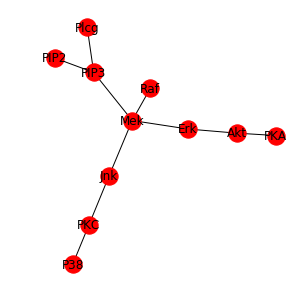

In [25]:
edgesSach = evolveProt; edgesLp = lp; edgespOn = pOn; edgespOff = pOff
#p = fullPlot(evolveProt, namesProt, 0.45)

ed = []
threshold = 0.45
for b in range(len(namesProt)**2):
    edge = np.array(evolveProt[:,b])
    edge = np.squeeze(edge)
    ed.append(edge[-1])
ed = np.asarray(ed)
ed = ed.reshape([11,11])
for b in range(11):
    for c in range(b):
        ed[c,b] += ed[b,c]
        ed[b,c] = 0
        
pred = np.double(np.asarray(ed) > threshold)
pred = pred.reshape([len(namesProt),len(namesProt)])

print(pred)
plot.rcParams['figure.figsize'] = [10, 5]
G = nx.Graph()
for j in range(11):
    for k in range(j, 11):
        if pred[j,k] == 1:
            G.add_edges_from([(namesProt[j], namesProt[k])])
plot.subplot(121)
nx.draw(G, with_labels = True)
#show(p)

In [167]:
car = pd.read_csv('cars.csv')
print(cars)

FileNotFoundError: [Errno 2] File b'cars.csv' does not exist: b'cars.csv'

In [9]:
def fullPlot(edges, names, cutoff):
    
    num = len(names)
    indices = list(range(num))
   
    #Nodes are colored based on how many outgoing connectiosn they have normalized by the max number of outgoing nodes:            
    p = figure(title = "Full Learned Graph", x_range = (-1.1,1.1), y_range = (-1.1,1.1))
    p.plot_width = 700
    p.plot_height = 700
    p.title.text_font_size = "15px"
    
    G = nx.Graph()
    G.add_nodes_from(indices)
    edge_attrs = {}
    undirected, directed = "black", "red"
    outgoing = sum(edges)
    outgoing = ndarray.flatten(array(outgoing))
    
    for j in range(num):
        G.node[j]['name'] = names[j]
        G.node[j]['numOut'] = str(outgoing[j])
        for k in range(num):
            if edges[j,k] > cutoff:
                G.add_edge(j,k)
                edge_attrs[(j,k)] = directed
                if edges[k,j] > cutoff:
                    edge_attrs[(j,k)] = undirected
            
    #nx.set_edge_attributes(G, edge_attrs, 'edgeColor')
    
    norm = max(outgoing) #the normalizing constant to help with colors
    for i in range(num):
        if outgoing[i] == 0:
            G.node[i]['colors'] = Spectral8[0]
            G.node[i]['sColors'] = Inferno8[0]
        else:
            G.node[i]['colors'] = Spectral8[int(len(Spectral8)*((outgoing[i] - .001)/norm))]
            G.node[i]['sColors'] = Inferno8[int(len(Inferno8)*((outgoing[i] - .001)/norm))]
            
    node_hover_tool = HoverTool(tooltips=[("Name", "@name")])
    p.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())
    
    graph_renderer = from_networkx(G, nx.circular_layout, scale=1, center=(0,0))

    circSource = dict(name = names)
    graph_renderer.node_renderer.glyph = Circle(size = 14, fill_color = 'colors', name = 'name', 
                                                tags = ['numOut', nx.get_node_attributes(G,'numOut')])
    graph_renderer.node_renderer.selection_glyph = Circle(size = 16, fill_color = 'sColors')
    graph_renderer.node_renderer.hover_glyph = Circle(size = 16, fill_color = 'sColors')

    graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=4)
    graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color = '#CCCCCC', line_width=6)
    graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color = '#CCCCCC', line_width = 6)
    #graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color = 'edgeColor', line_width=6)
    #graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color = 'edgeColor', line_width = 6)
    
    graph_renderer.selection_policy = NodesAndLinkedEdges()
    graph_renderer.inspection_policy = EdgesAndLinkedNodes()
    
    p.renderers.append(graph_renderer)
    
    return(p)

In [44]:
fileName = '.\speedTest.csv'
data = pd.read_csv(fileName)
dataDict = {'n': len(data.index), 'C': asarray(data.corr()), 'p': len(data.columns), 'mu': asarray(data.mean()),
            'Sn': asarray(data.cov())}
names = data.columns
output_notebook()

p = plt.figure(title = "Traces of all edges")
p.plot_width = 700
p.plot_height = 700
p.title.text_font_size = "15px"
p.yaxis.axis_label = "Probability of Edges"
p.xaxis.axis_label = "Number of Samples from the Posterior"
evolve, gs, lp, pOn, pOff = minIMAP_MCMC(dataDict, burnIn = 2500, alpha = 0.05, justEdges = True, gamma = 1, 
        nSteps = 5000, thinning = 1)
evolve = np.asmatrix(evolve)
for b in range(len(names)**2):
    edge = np.array(evolve[:,b])
    p.line(np.asarray([i for i in range(len(edge))]), np.ndarray.flatten(np.array(edge)), color = 'black')
show(p)

Loading BokehJS ...

5% Done!
10% Done!
15% Done!
20% Done!
25% Done!
30% Done!
35% Done!
40% Done!
45% Done!
50% Done!
55% Done!
60% Done!
65% Done!
70% Done!
75% Done!
80% Done!
85% Done!
90% Done!
95% Done!
100% Done!


In [21]:
dataFil = './ProteinDataFiles/sachs_data.txt'
sach = np.loadtxt(dataFil, skiprows = 1)
sach_log = log(sach)
with open(dataFil) as f:
    lines = [line.rstrip('\n') for line in f]
    namesProt = lines[0].split('\t')
sachDf = pd.DataFrame(sach_log)
mapper = dict()
for i in range(len(namesProt)):
    mapper[i] = namesProt[i]
sachDf = sachDf.rename(columns = mapper)
sachDf.to_csv('./ProteinDataFiles/sachs_data1.csv')

          Raf       Mek      Plcg      PIP2      PIP3       Erk       Akt  \
0    3.273364  2.580217  2.177022  2.906901  4.074142  1.888584  2.833213   
1    3.580737  2.803360  2.509599  2.821379  2.095561  2.923162  3.481240   
2    4.084294  3.786460  2.681022  2.322388  2.564949  2.701361  3.481240   
3    4.290459  4.416428  3.139833  2.602690  0.254642  1.763017  2.468100   
4    3.517498  2.985682  1.646734  2.275214  3.210844  3.049273  3.830813   
5    2.933857  1.321756  2.867899  3.095578  2.388763  2.476538  3.246491   
6    3.804438  3.597312  2.341806  4.882802  2.791165  2.158715  2.884801   
7    3.858622  2.708050  2.681022  3.417727  2.862201  3.005683  3.813307   
8    4.644391  4.119037  2.360854  3.049273  3.732896  2.442347  3.157000   
9    3.049273  3.068053  0.631272  5.323010  3.777348  2.580217  4.905275   
10   2.797281  2.797281  2.674149  2.833213  2.415914  3.086487  3.543854   
11   4.308111  3.131137  2.014903  2.740840  3.265759  3.039749  3.597312   

In [ ]:
colors = ['aliceblue',  'aqua', 'aquamarine', 'azure', 'beige', 'bisque',
          'black',  'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue',
          'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'crimson', 'cyan',
          'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki',
          'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon',
          'darkseagreen', 'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise',
          'darkviolet', 'deeppink', 'deepskyblue',   'dodgerblue', 'firebrick',
           'forestgreen', 'fuchsia', 'gainsboro',  'gold', 'goldenrod',
          'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo',
           'lavender', 'lavenderblush', 'lawngreen', 'lime', 'limegreen',  'magenta', 'maroon',
          'mediumaquamarine', 'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen',
          'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred', 'midnightblue',
          'mintcream', 'mistyrose', 'moccasin',  'navy',  'olive', 'olivedrab',
          'orange', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred',
          'papayawhip', 'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'red', 'rosybrown',
          'royalblue', 'saddlebrown', 'salmon', 'sandybrown', 'seagreen',  'sienna', 'silver',
          'skyblue', 'slateblue', 'slategray', 'slategrey',  'springgreen', 'steelblue', 'tan',
          'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'yellow', 'yellowgreen']